In [137]:
# реализуем  функцию, которая будет автоматически подгружать информацию из дополнительного файла groups_add.csv и на основании дополнительных параметров пересчитывать метрики.

import pandas as pd


def file_append_and_metrics_count(groups, groups_add, checks, active_studs):

# загружаем необходимые данные 
    groups = pd.read_csv('groups.csv', sep=';')
    groups = groups.rename(columns={groups.columns[0]: 'id', groups.columns[1]: 'grp'})

    groups_add = pd.read_csv('group_add.csv')
    groups_add = group_add.rename(columns={group_add.columns[0]: 'id', group_add.columns[1]: 'grp'})

    checks = pd.read_csv('checks.csv', sep=';')
    checks = checks.rename(columns={checks.columns[0]: 'id'})

    active_studs = pd.read_csv('active_studs.csv')
    active_studs = active_studs.rename(columns={active_studs.columns[0]: 'id'})
  
    
# объединим датафреймы, а также удалим дубликаты и пропуски    
    all_students = groups.merge(group_add, how='outer', on=['id', 'grp']).drop_duplicates().dropna()
    
# добавим колонку 'on_platform', где обозначим '1', что пользователь находился на платформе во время АВ теста
    active_studs.insert(loc=1, column='on_platform', value=1) 
   
# теперь получим таблицу со всеми пользователями, кто был и кого не было на платформе во время теста   
    all_students_ab = all_students.merge(active_studs, how='outer', on='id')
    
# при объединении таблиц у нас образовались пустые ячейки, которые указывают, что пользователя не было на платформе.
# при помощи метода fillna(0) заполним все пустые занчения - 0
    all_students_ab['on_platform'] = all_students_ab['on_platform'].fillna(0)
    all_students_ab = all_students_ab.merge(checks, how='outer', on='id')
    all_students_ab.rev = all_students_ab.rev.fillna(0)
    
# оставим только пользователей, которые присутствовали на платформе в дни теста
    be_on_platform = all_students_ab.query('on_platform == 1')  

# рассчитаем основные статистические параметры
# сначала рассчитаем для всех пользователей
    stat_describe_on_platform = be_on_platform.groupby('grp').rev.describe().reset_index() 
    print(stat_describe_on_platform)

# теперь рассчитаем основные показатели для клиентов, т.е. те, кто совершил оплату
    students_rev = be_on_platform.query('rev != 0')  
    stat_describe = students_rev.groupby('grp').rev.describe().reset_index() 
    print(stat_describe)

# разделим пользователей по группам
    a_group = be_on_platform.query('grp == "A"')
    b_group = be_on_platform.query('grp == "B"')
    
# рассчитаем метрики
    cr_a_gr = (a_group[a_group.rev != 0].rev.count() / a_group.rev.count() * 100).round(2)
    cr_b_gr = (b_group[b_group.rev != 0].rev.count() / b_group.rev.count() * 100).round(2)
    arpu_a = (a_group.rev.sum() / a_group.id.nunique()).round(2)
    arpu_b = (b_group.rev.sum() / b_group.id.nunique()).round(2)
    mean_rev_a = a_group.query('rev!=0').rev.mean().round(2)
    mean_rev_b = b_group.query('rev!=0').rev.mean().round(2)
    
# создадим датафрейм со всеми метриками
    df = pd.DataFrame({'group': ['A', 'B'],
                       'count_students': [stat_describe_on_platform['count'][0],
                                          stat_describe_on_platform['count'][1]],
                       'count_clients': [stat_describe['count'][0],
                                         stat_describe['count'][1]],
                       'CR%': [cr_a_gr, cr_b_gr],
                       'ARPU': [arpu_a, arpu_b],
                       'mean_rev_clients': [mean_rev_a, mean_rev_b]})
    
    return df

In [138]:
metrics_df = file_append_and_metrics_count(groups, groups_add, checks, active_studs)
metrics_df

  grp   count       mean         std  min  25%  50%  75%     max
,0   A  1538.0  47.347204  290.490632  0.0  0.0  0.0  0.0  3660.0
,1   B  6803.0  58.058798  313.770201  0.0  0.0  0.0  0.0  4650.0
,  grp  count         mean         std    min     25%     50%      75%     max
,0   A   78.0   933.589744  919.932711  199.0  290.00   585.0  1114.75  3660.0
,1   B  314.0  1257.878992  790.864254  199.0  511.75  1140.0  1900.00  4650.0


,group,count_students,count_clients,CR%,ARPU,mean_rev_clients
0,A,1538.0,78.0,5.07,47.35,933.59
1,B,6803.0,314.0,4.62,58.06,1257.88


<Figure size 2000x600 with 0 Axes>

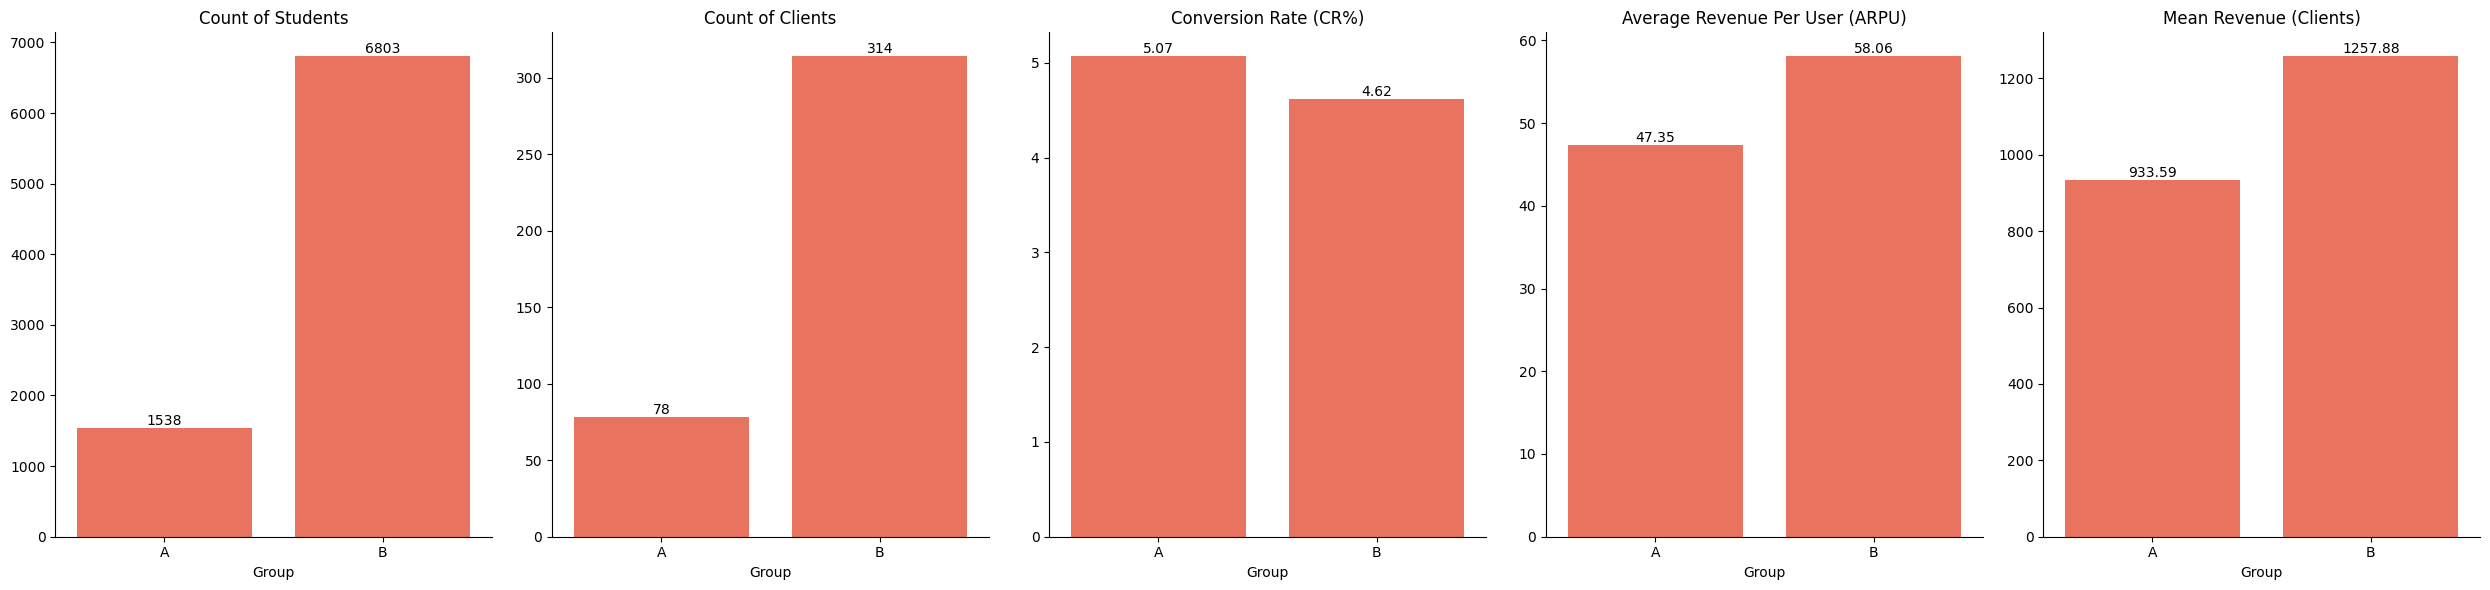

In [80]:
# реализуем функцию, которая будет строить графики по получаемым метрикам.

%pip install seaborn
import seaborn as sns
import matplotlib.pyplot as plt

def draw_plot(metrics):
    """
    Функция для построения графиков на основе метрик.
    """
    # Устанавливаем цветовую палитру
    colors = ["#FF6347", "#32CD32"]  # Красный и зеленый
    sns.set_palette(sns.color_palette(colors))

    # Увеличиваем размер графиков
    plt.figure(figsize=(20, 6))

    # Создаем 5 подграфиков
    fig, axes = plt.subplots(1, 5, figsize=(25, 6))

    # Построение графиков
    sns.barplot(x='group', y='count_students', data=metrics, ax=axes[0])
    axes[0].set_title('Count of Students')
    axes[0].set_ylabel('')
    axes[0].set_xlabel('Group')
    axes[0].bar_label(axes[0].containers[0], fmt='%.0f')  # Подписи значений

    sns.barplot(x='group', y='count_clients', data=metrics, ax=axes[1])
    axes[1].set_title('Count of Clients')
    axes[1].set_ylabel('')
    axes[1].set_xlabel('Group')
    axes[1].bar_label(axes[1].containers[0], fmt='%.0f')

    sns.barplot(x='group', y='CR%', data=metrics, ax=axes[2])
    axes[2].set_title('Conversion Rate (CR%)')
    axes[2].set_ylabel('')
    axes[2].set_xlabel('Group')
    axes[2].bar_label(axes[2].containers[0], fmt='%.2f')

    sns.barplot(x='group', y='ARPU', data=metrics, ax=axes[3])
    axes[3].set_title('Average Revenue Per User (ARPU)')
    axes[3].set_ylabel('')
    axes[3].set_xlabel('Group')
    axes[3].bar_label(axes[3].containers[0], fmt='%.2f')

    sns.barplot(x='group', y='mean_rev_clients', data=metrics, ax=axes[4])
    axes[4].set_title('Mean Revenue (Clients)')
    axes[4].set_ylabel('')
    axes[4].set_xlabel('Group')
    axes[4].bar_label(axes[4].containers[0], fmt='%.2f')

    # Удаляем лишние линии
    sns.despine()

    # Показ графиков
    plt.tight_layout()
    plt.show()
draw_plot(metrics_df)